# A confidence Analysis - PRECISE-1K

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns

from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

## Load the data from ./Data/ folder

In [2]:
precise1k = load_json_model('../Data/p1k.json.gz')

In [3]:
P1K_Gene_Presence_Matrix = pd.read_csv("../Data/P1K_Gene_Presence_Matrix.csv", index_col=0)

In [4]:
RegulonDB_TRN = pd.read_csv('../Data/RegulonDB_TRN_C_and_S.csv', index_col = 0)

### PRECISE-1K: X M A log_tpm gene_presence_matrix

In [5]:
P1K_M = precise1k.M

In [6]:
P1K_A = precise1k.A

In [7]:
P1K_X = precise1k.X

In [8]:
P1K_log_tpm = precise1k.log_tpm

## A confidence calculation

In [9]:
def calculate_confidence_level(P1K_X, P1K_M, P1K_Gene_Presence_Matrix):
    """
    Calculate the absolute confidence level matrix A_confidence_level, limited to genes present in each component,
    with handling for components with fewer than two present genes (fills with 0 if less than two genes).
    
    Parameters:
    P1K_X (DataFrame): Gene expression matrix with dimensions (genes, samples).
    P1K_M (DataFrame): Component matrix with dimensions (genes, components).
    P1K_Gene_Presence_Matrix (DataFrame): Gene presence matrix with dimensions (genes, components),
                                          with True/False values indicating gene presence in each component.
    
    Returns:
    DataFrame: Absolute confidence level matrix with dimensions matching (components, samples).
    """
    # Initialize the output matrix
    components, samples = P1K_M.shape[1], P1K_X.shape[1]
    A_confidence_level = pd.DataFrame(np.zeros((components, samples)), 
                                      index=P1K_M.columns, columns=P1K_X.columns)

    # Calculate absolute correlation for each component-sample pair, limited to present genes
    for comp in P1K_M.columns:
        present_genes = P1K_Gene_Presence_Matrix[P1K_Gene_Presence_Matrix[comp]].index  # Select genes present in the component
        
        # If fewer than two genes are present, fill with 0
        if len(present_genes) < 2:
            A_confidence_level.loc[comp, :] = 0
            continue

        for samp in P1K_X.columns:
            gene_expression = P1K_X.loc[present_genes, samp]
            gene_weights = P1K_M.loc[present_genes, comp]
            correlation = abs(gene_expression.corr(gene_weights))
            A_confidence_level.loc[comp, samp] = correlation

    return A_confidence_level

In [10]:
A_confidence_level = calculate_confidence_level(P1K_X, P1K_M, P1K_Gene_Presence_Matrix)

In [11]:
import matplotlib.pyplot as plt

def plot_confidence_level_distribution(A_confidence_level):
    """
    Plot the distribution of all values in the A_confidence_level matrix.
    
    Parameters:
    A_confidence_level (DataFrame): Confidence level matrix with dimensions (components, samples).
    """
    # Flatten the matrix to get all values as a single array
    values = A_confidence_level.values.flatten()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=30, edgecolor='black', alpha=0.7)
    plt.title("Distribution of Confidence Levels in A_confidence_level")
    plt.xlabel("Absolute Correlation")
    plt.ylabel("Frequency")
    plt.show()

In [12]:
A_confidence_level

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
Sugar Diacid,0.081670,0.081670,0.564850,0.441786,0.310102,0.391721,0.340699,0.496643,0.134094,0.098667,...,0.319605,0.608515,0.704622,0.496838,0.352245,0.474974,0.176807,0.213999,0.015733,0.139463
Translation,0.127350,0.127350,0.092950,0.053123,0.198337,0.245798,0.214245,0.000026,0.103549,0.076088,...,0.045315,0.017418,0.035407,0.016790,0.066146,0.083978,0.275060,0.017573,0.141725,0.080840
ygdT,0.646722,0.646722,0.832404,0.772961,0.274782,0.614620,0.997822,0.941315,0.772678,0.943113,...,0.453000,0.952221,0.520879,0.989593,0.520276,0.453000,0.520078,0.421553,0.974390,0.722859
OxyR,0.293098,0.293098,0.050835,0.071920,0.023429,0.079123,0.050861,0.090543,0.046688,0.035965,...,0.217509,0.283162,0.263682,0.280271,0.455668,0.423084,0.334598,0.340875,0.494358,0.400986
FlhDC-2,0.406306,0.406306,0.661655,0.674238,0.861525,0.706397,0.700223,0.700747,0.387368,0.642858,...,0.412675,0.015298,0.043182,0.010941,0.175532,0.033088,0.538110,0.510883,0.183975,0.203843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glyoxylate,0.487514,0.487514,0.680956,0.693526,0.497613,0.108047,0.512570,0.733340,0.926754,0.874494,...,0.108230,0.557896,0.186932,0.391013,0.014711,0.001288,0.410023,0.922554,0.232164,0.819144
CCK-PGI Del,0.012696,0.012696,0.202191,0.277913,0.295075,0.288672,0.247345,0.232186,0.282232,0.529729,...,0.192973,0.130692,0.253759,0.249936,0.310710,0.373305,0.034214,0.047555,0.104161,0.202272
Acetate,0.596451,0.596451,0.547440,0.610480,0.909907,0.728975,0.511025,0.707223,0.828652,0.699140,...,0.858066,0.862495,0.920952,0.798961,0.923974,0.890126,0.671428,0.951186,0.948559,0.953022
Ile/Val,0.513826,0.513826,0.645809,0.660743,0.001900,0.863554,0.750677,0.641991,0.823502,0.749427,...,0.752396,0.701051,0.878063,0.596020,0.945029,0.945064,0.747843,0.669497,0.973387,0.747979


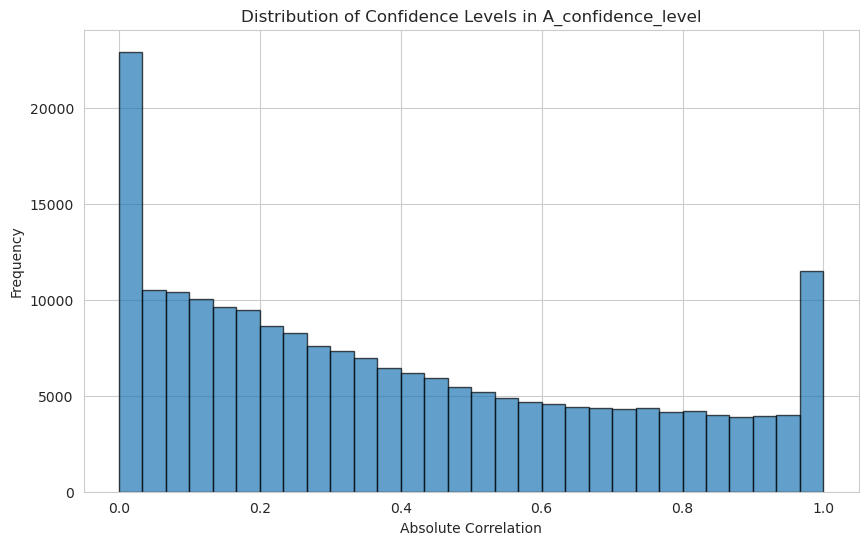

In [13]:
plot_confidence_level_distribution(A_confidence_level)

### Plot the confidence level v.s. Activity

In [16]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_confidence_vs_activity(A_confidence_level, P1K_A, component='RpoS'):
    """
    Plot a scatter plot of confidence vs. activity for a specified component.

    Parameters:
    A_confidence_level (DataFrame): Confidence level matrix with dimensions (components, samples).
    P1K_A (DataFrame): Activity matrix with dimensions matching A_confidence_level.
    component (str): The component to plot (default is 'RpoS').
    """
    # Extract the confidence and activity values for the specified component
    confidence_values = A_confidence_level.loc[component]
    activity_values = P1K_A.loc[component]
    
    # Set the font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Plot confidence vs. activity
    plt.figure(figsize=(4, 4))
    plt.scatter(confidence_values, activity_values, color='#9367AC', alpha=0.7)
    plt.title(f"Confidence vs. Activity for iM: {component}", fontproperties=font_prop)
    plt.xlabel("Confidence Level (A_confidence_level)", fontproperties=font_prop)
    plt.ylabel("Activity Level (P1K_A)", fontproperties=font_prop)
    plt.xlim(0,1)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black box surrounding it with width = 1
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.show()

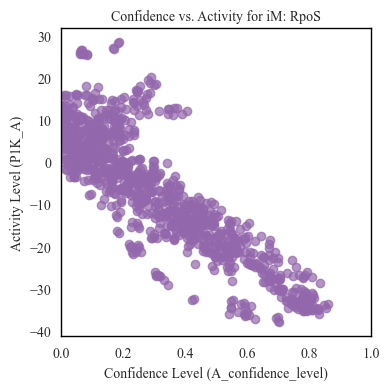

In [80]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='RpoS')

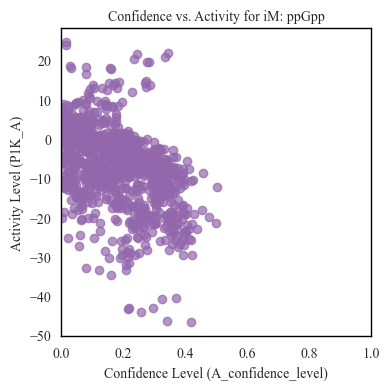

In [18]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='ppGpp')

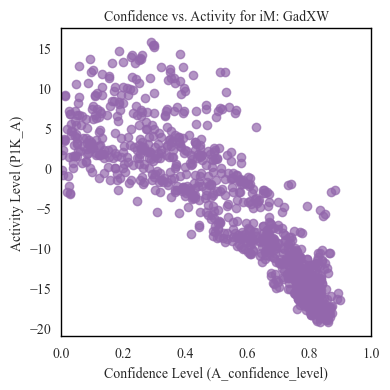

In [19]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='GadXW')

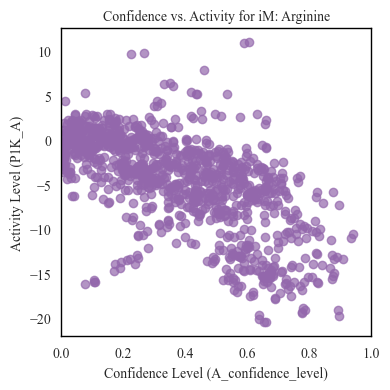

In [20]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Arginine')

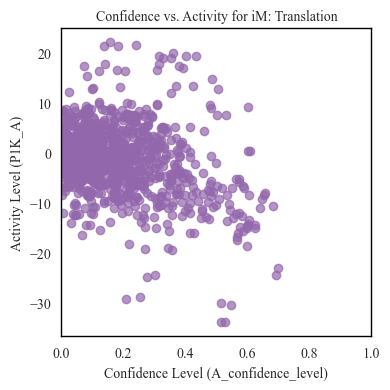

In [21]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Translation')

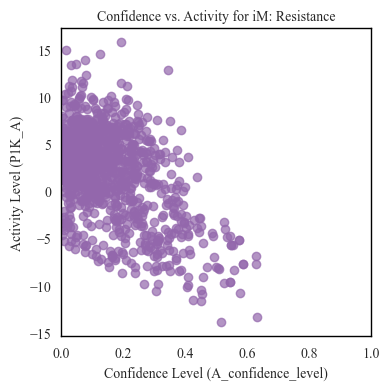

In [22]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Resistance')

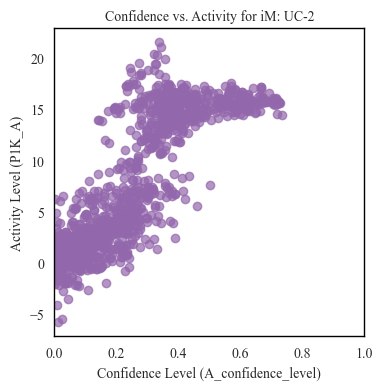

In [23]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='UC-2')

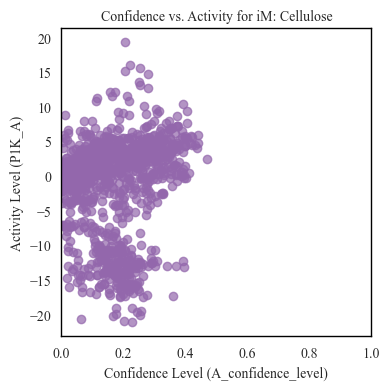

In [24]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Cellulose')

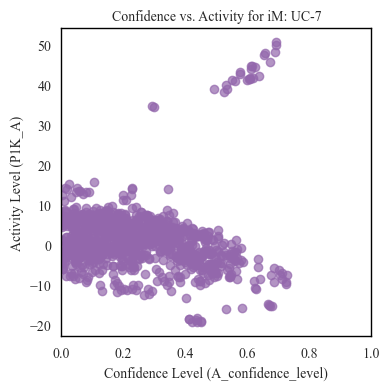

In [25]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='UC-7')

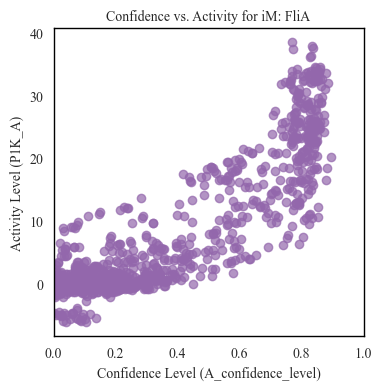

In [26]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='FliA')

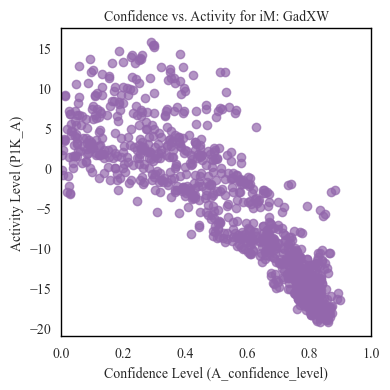

In [27]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='GadXW')

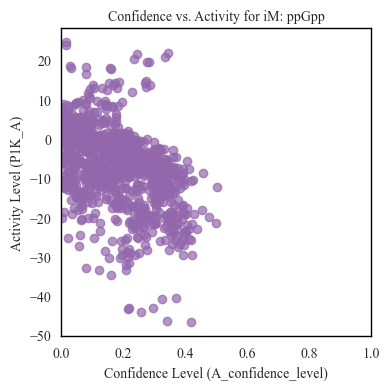

In [28]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='ppGpp')

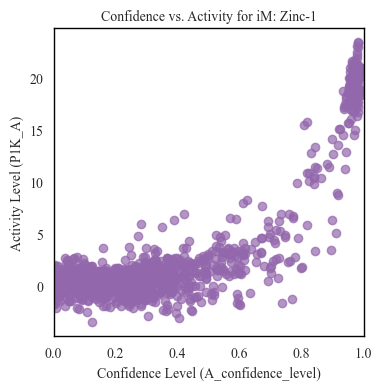

In [29]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Zinc-1')

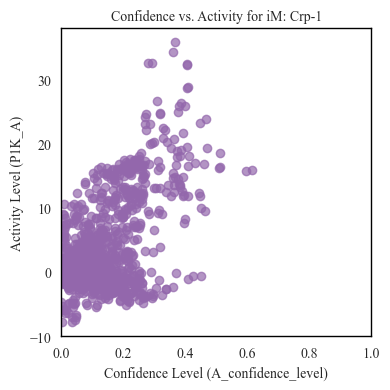

In [30]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Crp-1')

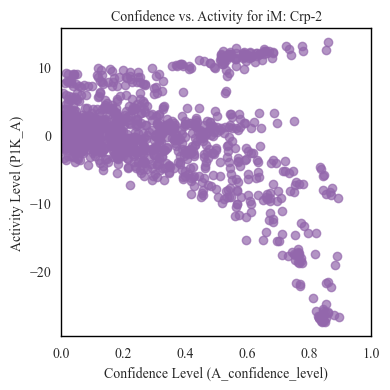

In [31]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='Crp-2')

## calculate overall confidence

In [37]:
def calculate_overall_confidence_top_correlation(A_confidence_level, P1K_A, top_percent=10):
    """
    Calculate the overall confidence for each component by averaging the top absolute activity values across samples.
    
    Parameters:
    A_confidence_level (DataFrame): Confidence level matrix with dimensions (components, samples).
    P1K_A (DataFrame): Activity matrix with the same dimensions as A_confidence_level.
    top_percent (float): Percentage of top absolute activity values to use for averaging (default is 20%).
    
    Returns:
    DataFrame: DataFrame with a single column 'Overall_Confidence', ranked from high to low.
    """
    # Determine the number of samples to consider based on the top percentage
    num_top_samples = int(np.ceil(top_percent / 100 * A_confidence_level.shape[1]))

    # Initialize the list to store mean confidence levels
    overall_confidence = []

    # Calculate the mean confidence level for each component based on top absolute activity values
    for comp in A_confidence_level.index:
        # Get the absolute activity levels and confidence levels for this component across samples
        activity_levels = P1K_A.loc[comp].abs()
        confidence_levels = A_confidence_level.loc[comp]
        
        # Identify the indices of the top absolute activity values
        top_activity_indices = confidence_levels.nlargest(num_top_samples).index
        
        # Calculate the mean confidence level based on the top absolute activity values
        mean_confidence = confidence_levels[top_activity_indices].mean()
        overall_confidence.append(mean_confidence)
    
    # Create a DataFrame with the results and sort by 'Overall_Confidence' in descending order
    overall_confidence_df = pd.DataFrame(overall_confidence, index=A_confidence_level.index, columns=['Overall_Confidence'])
    overall_confidence_df = overall_confidence_df.sort_values(by='Overall_Confidence', ascending=False)

    return overall_confidence_df

In [38]:
overall_confidence = calculate_overall_confidence_top_correlation(A_confidence_level, P1K_A)

<AxesSubplot:>

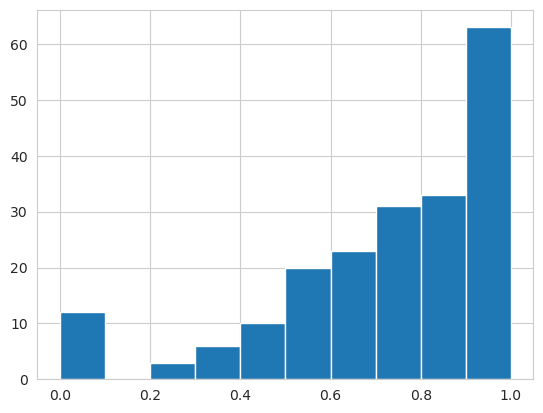

In [39]:
overall_confidence['Overall_Confidence'].hist()

In [42]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_overall_confidence_vs_component_size(overall_confidence_df, P1K_Gene_Presence_Matrix):
    """
    Plot Overall Confidence against Component Size (number of 'True' values per component).

    Parameters:
    overall_confidence_df (DataFrame): DataFrame with 'Overall_Confidence' for each component.
    P1K_Gene_Presence_Matrix (DataFrame): Gene presence matrix indicating presence (True) of genes in components.
    """
    # Calculate component size (number of 'True' values) for each component
    component_size = P1K_Gene_Presence_Matrix.sum(axis=0)
    
    # Merge overall confidence and component size data for plotting
    plot_data = overall_confidence_df.join(component_size.rename("Component_Size"))
    
    # Set the font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Plot Overall Confidence vs. Component Size
    plt.figure(figsize=(4, 4))
    plt.scatter(plot_data['Overall_Confidence'], plot_data['Component_Size'], color='#9367AC', alpha=0.7)
    plt.title("Top 10% Confidence vs. iM Size", fontproperties=font_prop)
    plt.xlabel("Top 10% Confidence", fontproperties=font_prop)
    plt.ylabel("iM Size (Number of Genes)", fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove grid
    plt.grid(False)
    
    # Add a black box surrounding it with width = 1
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.show()

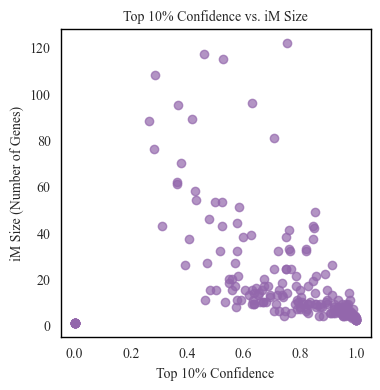

In [43]:
plot_overall_confidence_vs_component_size(overall_confidence, P1K_Gene_Presence_Matrix)

In [44]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.font_manager as fm

def plot_overall_confidence_vs_component_size_with_labels_adjusted_range(
        overall_confidence_df, P1K_Gene_Presence_Matrix, 
        label_threshold=60, confidence_min=0.95, confidence_max=0.95):
    """
    Plot Overall Confidence against Component Size (number of 'True' values per component),
    with labels for components that have more than a specified number of genes or confidence within a specified range.

    Parameters:
    overall_confidence_df (DataFrame): DataFrame with 'Overall_Confidence' for each component.
    P1K_Gene_Presence_Matrix (DataFrame): Gene presence matrix indicating presence (True) of genes in components.
    label_threshold (int): Threshold for labeling components with more than this number of genes (default is 80).
    confidence_min (float): Minimum confidence level for labeling components (default is 0.9).
    confidence_max (float): Maximum confidence level for labeling components (default is 0.95).
    """
    # Calculate component size (number of 'True' values) for each component
    component_size = P1K_Gene_Presence_Matrix.sum(axis=0)
    
    # Merge overall confidence and component size data for plotting
    plot_data = overall_confidence_df.join(component_size.rename("Component_Size"))
    
    # Set the font properties
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=10)

    # Plot Overall Confidence vs. Component Size with adjusted plot size
    plt.figure(figsize=(4, 4))
    plt.scatter(plot_data['Overall_Confidence'], plot_data['Component_Size'], color='#9367AC', alpha=0.7)
    
    # Collect text labels for components meeting the size or confidence range criteria
    texts = []
    for comp, row in plot_data.iterrows():
        if (row['Component_Size'] > label_threshold or 
            (confidence_min <= row['Overall_Confidence'] <= confidence_max)):
            texts.append(plt.text(row['Overall_Confidence'], row['Component_Size'], comp, 
                                  fontproperties=font_prop))
    
    # Adjust text to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    plt.title("Top 10% Confidence vs. iM Size", fontproperties=font_prop)
    plt.xlabel("Top 10% Confidence", fontproperties=font_prop)
    plt.ylabel("iM Size (Number of Genes)", fontproperties=font_prop)
    
    # Set font properties for tick labels
    plt.xticks(fontproperties=font_prop)
    plt.yticks(fontproperties=font_prop)
    
    # Remove grid and add a black border
    plt.grid(False)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    plt.show()


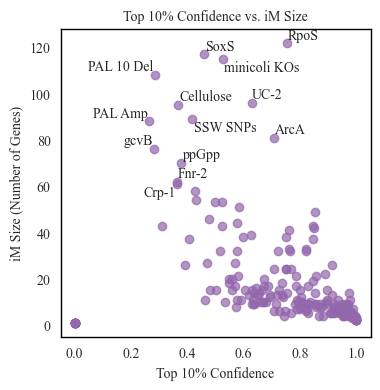

In [45]:
plot_overall_confidence_vs_component_size_with_labels_adjusted_range(overall_confidence, P1K_Gene_Presence_Matrix)

In [81]:
overall_confidence.to_csv('overall_confidence.csv')

### RpoS

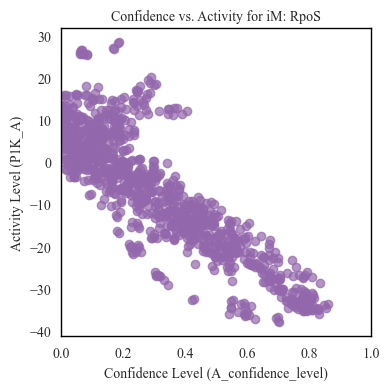

In [46]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='RpoS')

In [47]:
A_confidence_level.loc['RpoS']

p1k_00001    0.047373
p1k_00002    0.047373
p1k_00003    0.300027
p1k_00004    0.285186
p1k_00005    0.073090
               ...   
p1k_01051    0.731215
p1k_01052    0.181428
p1k_01053    0.008110
p1k_01054    0.100163
p1k_01055    0.120945
Name: RpoS, Length: 1035, dtype: float64

In [48]:
P1K_A.loc['RpoS']

p1k_00001     0.249722
p1k_00002    -0.249722
p1k_00003    18.259383
p1k_00004    18.741579
p1k_00005    -1.598087
               ...    
p1k_01051   -34.665247
p1k_01052     7.973166
p1k_01053    11.096650
p1k_01054     5.214782
p1k_01055     5.662713
Name: RpoS, Length: 1035, dtype: float64

In [79]:
def analyze_activity_confidence_sections(A_confidence_level, P1K_A, component='RpoS', sections=10):
    """
    Analyzes activity data by splitting the range of activity into sections, then finds the columns 
    with the highest and lowest confidence within each section.
    
    Parameters:
    A_confidence_level (DataFrame): Confidence level matrix with dimensions (components, samples).
    P1K_A (DataFrame): Activity matrix with dimensions matching A_confidence_level.
    component (str): The component to analyze (default is 'RpoS').
    sections (int): Number of sections to split the activity range into (default is 10).
    
    Returns:
    DataFrame: DataFrame containing section boundaries and column names with highest and lowest confidence.
    """
    # Extract the confidence and activity values for the specified component
    confidence_values = A_confidence_level.loc[component]
    activity_values = P1K_A.loc[component]
    
    # Define the bins based on the activity range
    min_activity, max_activity = activity_values.min(), activity_values.max()
    bins = np.linspace(min_activity, max_activity, sections + 1)
    
    # Prepare a list to store the results
    results = []

    # Loop over each section
    for i in range(sections):
        # Define the range for the current section
        lower_bound, upper_bound = bins[i], bins[i + 1]
        
        # Filter values within the current section
        section_mask = (activity_values >= lower_bound) & (activity_values < upper_bound)
        section_confidences = confidence_values[section_mask]
        
        if not section_confidences.empty:
            # Find the columns with highest and lowest confidence in this section
            highest_confidence_col = section_confidences.idxmax()
            lowest_confidence_col = section_confidences.idxmin()
            
            # Store the section range and corresponding column names
            results.append({
                "Activity Range": f"{lower_bound:.2f} to {upper_bound:.2f}",
                "Highest Confidence Column": highest_confidence_col,
                "Lowest Confidence Column": lowest_confidence_col,
                "Highest Confidence Value": section_confidences[highest_confidence_col],
                "Lowest Confidence Value": section_confidences[lowest_confidence_col]
            })
    
    # Convert results into a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

In [50]:
analyze_activity_confidence_sections(A_confidence_level, P1K_A, component='RpoS', sections=10)

,Activity Range,Highest Confidence Column,Lowest Confidence Column,Highest Confidence Value,Lowest Confidence Value
0,-38.07 to -31.44,p1k_00135,p1k_00840,0.859885,0.422486
1,-31.44 to -24.80,p1k_00270,p1k_00826,0.833229,0.302074
2,-24.80 to -18.17,p1k_00264,p1k_00844,0.744491,0.216521
3,-18.17 to -11.53,p1k_00697,p1k_00747,0.644597,0.177491
4,-11.53 to -4.90,p1k_00260,p1k_00533,0.516363,0.089485
5,-4.90 to 1.74,p1k_00057,p1k_00225,0.367780,0.006259
6,1.74 to 8.37,p1k_01033,p1k_00929,0.234447,0.000870
7,8.37 to 15.01,p1k_00121,p1k_00956,0.404535,0.001750
8,15.01 to 21.64,p1k_00007,p1k_00973,0.306638,0.001762
9,21.64 to 28.28,p1k_00067,p1k_00463,0.181514,0.058961


In [51]:
P1K_A.loc['RpoS']['p1k_00264']

-23.21055612221105

In [52]:
P1K_A.loc['RpoS']['p1k_00844']

-19.42354045600816

## Overview of the activity confidence

In [53]:
overall_confidence

,Overall_Confidence
arcA/luxS KO,1.0
Tryptophanase,1.0
Efflux Pump,1.0
Nickel/Cobalt,1.0
yjjZ,1.0
...,...
ydfB,0.0
yceO,0.0
ymdG,0.0
ldrA,0.0


In [54]:
P1K_iM_table = pd.read_csv('../Data/imodulon_table.csv', index_col=0)

In [55]:
P1K_iM_table

,exp_var,imodulon_size,enrichment_category,system_category,functional_category,function,regulator,n_regs,pvalue,qvalue,...,single_gene_dominant_technical,tcs,regulon_discovery,ko,PRECISE 2.0,PRECISE 2.0_pearson,PRECISE 2.0_spearman,PRECISE,PRECISE_pearson,PRECISE_spearman
Sugar Diacid,0.002413,14,Regulatory,Metabolism,Carbon Metabolism,Transport and catabolism of carbohydrate diaci...,CdaR,1.0,1.595767e-24,7.110896e-20,...,False,False,False,False,CdaR,0.952054,0.758726,CdaR,0.905552,0.562704
Translation,0.007469,53,Regulatory,Translation,Translation,Ribosome biogenesis,DksA,1.0,7.972755e-65,5.125923e-60,...,False,False,False,False,Translation,0.892858,0.764432,translation,0.667232,0.482602
ygdT,0.000344,3,Technical,Single Gene,Unknown,Unknown,NaN,NaN,NaN,NaN,...,True,False,False,False,SG_ygdT,0.653472,0.422661,NaN,NaN,NaN
OxyR,0.001747,38,Regulatory,Stress Responses,Redox Stress,"Oxidative stress response, especially peroxide",OxyR,1.0,2.620144e-27,4.708660e-23,...,False,False,False,False,OxyR,0.926352,0.730520,OxyR,0.621129,0.254705
FlhDC-2,0.030021,43,Regulatory,Stress Responses,Extracellular Structures,Flagellum biosynthesis and export,FlhDC,1.0,7.733764e-62,3.447790e-57,...,False,False,False,False,FlhDC-2,0.917180,0.439455,FlhDC,0.907624,0.310641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glyoxylate,0.002085,3,Regulatory,Metabolism,Energy Metabolism,Glyxoylate cycle; alternate to TCA cycle,Crp+ArcA+ppGpp+Cra+IclR+IHF,6.0,0.000000e+00,NaN,...,False,False,False,False,Glyoxylate,0.674254,0.559924,NaN,NaN,NaN
CCK-PGI Del,0.000745,15,Genomic,ALE Effects,Unknown,Unknown,NaN,NaN,NaN,NaN,...,False,False,False,False,CCK-PGI Del,0.790822,0.685099,NaN,NaN,NaN
Acetate,0.006191,7,Biological,Metabolism,Carbon Metabolism,Acetate uptake and catabolism; aldehyde catabo...,NaN,NaN,NaN,NaN,...,False,False,False,False,NaN,NaN,NaN,Crp-1,0.323768,NaN
Ile/Val,0.001082,4,Biological,Metabolism,Amino Acid Metabolism,Isoleucine and valine biosynthesis,NaN,NaN,NaN,NaN,...,False,False,False,False,AHAS I,0.651289,0.510184,NaN,NaN,NaN


In [56]:
# Reindexing P1K_iM_table to match the order of overall_confidence
P1K_iM_table_aligned = P1K_iM_table.reindex(overall_confidence.index)

# Adding 'enrichment_category' and 'system_category' columns from P1K_iM_table to overall_confidence
overall_confidence = overall_confidence.assign(
    enrichment_category=P1K_iM_table_aligned['enrichment_category'],
    system_category=P1K_iM_table_aligned['system_category']
)

In [57]:
overall_confidence

,Overall_Confidence,enrichment_category,system_category
arcA/luxS KO,1.0,Genomic,Genetic Alterations
Tryptophanase,1.0,Regulatory,Metabolism
Efflux Pump,1.0,Biological,Stress Responses
Nickel/Cobalt,1.0,Regulatory,Stress Responses
yjjZ,1.0,Technical,Single Gene
...,...,...,...
ydfB,0.0,Technical,Single Gene
yceO,0.0,Technical,Single Gene
ymdG,0.0,Technical,Single Gene
ldrA,0.0,Technical,Single Gene


In [82]:
overall_confidence[overall_confidence['enrichment_category'] == 'Genomic']

,Overall_Confidence,enrichment_category,system_category
malE OE,0.999658,Genomic,Genetic Alterations
trxC Del,0.994974,Genomic,ALE Effects
cyoB/ndh/nuoB KO-1,0.990836,Genomic,Genetic Alterations
pgi KO,0.960856,Genomic,Genetic Alterations
sdh KO,0.954791,Genomic,Genetic Alterations
crp KO-2,0.948432,Genomic,Genetic Alterations
ROS TALE Amp,0.918906,Genomic,ALE Effects
BW25113,0.913191,Genomic,Genetic Alterations
entC/ubiC KO-2,0.906650,Genomic,Genetic Alterations
IS1,0.896737,Genomic,Unknown


In [58]:
overall_confidence[overall_confidence['enrichment_category'] == 'Biological']

,Overall_Confidence,enrichment_category,system_category
Efflux Pump,1.000000,Biological,Stress Responses
Acid Shock RNA,0.998006,Biological,Stress Responses
CP4-44,0.995251,Biological,Unknown
Ile/Val,0.972743,Biological,Metabolism
Acetate,0.950459,Biological,Metabolism
Thiamine-2,0.943302,Biological,Metabolism
Oxidoreductase,0.924906,Biological,Stress Responses
Cold Shock,0.897198,Biological,Stress Responses
IS Elements-2,0.852175,Biological,Unknown
Salicylic Acid,0.828956,Biological,Stress Responses


In [83]:
overall_confidence[overall_confidence['enrichment_category'] == 'Technical']

,Overall_Confidence,enrichment_category,system_category
ythA,0.996372,Technical,Single Gene
ydfW,0.993804,Technical,Single Gene
ygdT,0.985883,Technical,Single Gene
ydaG,0.952850,Technical,Single Gene
ldrD,0.951722,Technical,Single Gene
ymgI,0.868426,Technical,Single Gene
ypjJ,0.789778,Technical,Single Gene
yneP,0.706758,Technical,Single Gene
IS5,0.635181,Technical,Unknown


In [59]:
overall_confidence[overall_confidence['enrichment_category'] == 'Unknown']

,Overall_Confidence,enrichment_category,system_category
UC-9,0.791749,Unknown,Unknown
UC-8,0.715386,Unknown,Unknown
UC-6,0.634408,Unknown,Unknown
UC-2,0.628674,Unknown,Unknown
UC-4,0.624095,Unknown,Unknown
UC-3,0.582106,Unknown,Unknown
UC-7,0.574743,Unknown,Unknown
UC-5,0.480293,Unknown,Unknown
UC-1,0.470455,Unknown,Unknown


In [60]:
overall_confidence = overall_confidence[
    ~overall_confidence['Overall_Confidence'].isin([0, 1])
]

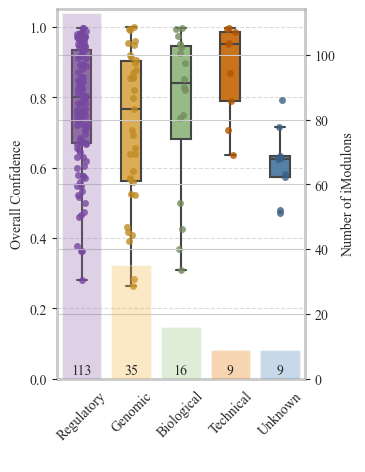

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Define font properties
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
font_prop = fm.FontProperties(fname=font_path, size=10)

# Define colors for the boxplots and deeper colors for the points
boxplot_colors = ['#9367ac', '#f2b341', '#94c47d', '#e67300', '#4682b4']
point_colors = ['#6b3b9a', '#be8b24', '#748c5e', '#b35400', '#3a6084']  # Deeper versions for points

# Specifying the order for the x-axis categories
category_order = ['Regulatory', 'Genomic', 'Biological', 'Technical', 'Unknown']

# Create a figure with a single y-axis
fig, ax1 = plt.subplots(figsize=(3.2, 4.8))

# Plotting the boxplot for 'Overall_Confidence' distribution with specified order
sns.boxplot(
    data=overall_confidence,
    x='enrichment_category',
    y='Overall_Confidence',
    ax=ax1,
    width=0.4,  # Reduced width
    palette=boxplot_colors[:len(category_order)],
    order=category_order,  # Specify the order of categories
    showfliers=False  # Optionally hide outliers
)
ax1.set_ylabel('Overall Confidence', fontproperties=font_prop)
ax1.set_xlabel(' ')  # Removing x-label
ax1.set_ylim(0, 1.05)  # Setting y-axis limits
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties(font_prop)

# Adding individual data points for each category using deeper versions of the boxplot colors
for i, category in enumerate(category_order):
    sns.stripplot(
        data=overall_confidence[overall_confidence['enrichment_category'] == category],
        x='enrichment_category',
        y='Overall_Confidence',
        ax=ax1,
        jitter=True,
        size=5,  # Adjust point size
        alpha=0.8,  # Transparency of points
        color=point_colors[i],  # Match deeper color for points
        order=category_order  # Specify the order of categories
    )

# Creating a secondary y-axis to plot the count of entries for each category
ax2 = ax1.twinx()
category_counts = overall_confidence['enrichment_category'].value_counts().reindex(category_order)
bars = ax2.bar(
    category_counts.index,
    category_counts.values,
    alpha=0.3,
    color=boxplot_colors[:len(category_counts)],  # Use the same colors as boxplots for consistency
    width=0.8  # Set bar width
)
ax2.set_ylabel('Number of iModulons', fontproperties=font_prop)
ax2.set_xlabel('')
ax2.set_ylim(0, max(category_counts.values) + 1)  # Set y-axis for bar counts
for label in ax2.get_yticklabels():
    label.set_fontproperties(font_prop)

# Adding count labels at the bottom of the bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, 0.5, str(int(height)), ha='center', va='bottom', fontproperties=font_prop)

# Adding a surrounding black box with width = 1
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
    
plt.savefig('confidence_overview.svg', format='svg', bbox_inches='tight')

# Save or display the figure
plt.show()

In [89]:
P1K_A.loc['IS Elements-2']['p1k_00987']

27.569891072626334

In [86]:
P1K_A.loc['RpoS']['p1k_00844']

-19.42354045600816

In [90]:
P1K_A.loc['IS Elements-2']['p1k_00754']

9.527524080296176

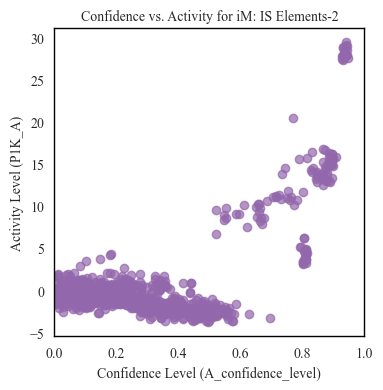

In [91]:
plot_confidence_vs_activity(A_confidence_level, P1K_A, component='IS Elements-2')

In [92]:
A_confidence_level.loc['IS Elements-2']['p1k_00754']

0.5220932092814671